# 00 - Stacking

## Introdução

Ensemble é um conjunto de modelos de machine learning. Usamos mais de um tipo de modelo para fazer previsão, onde cada um influencia no resultado (podemos fazer uma média entre as previsões dos modelos do ensemble e dar assim o resultado final).

Stacking é um método de Ensemble bem sucedido. No Stacking a ideia é usar as previsões de um modelo para treinar outro modelo. Por exemplo, podemos inicialmente aplicar os modelos de light gbm e uma rede neural aos dados, e depois aplicar uma modelo de regressão linear sobre as saídas desses dois modelos. A saída desses dois modelos originais são as features para treinamento do modelo de regressão linear.

Dessa forma o modelo de regressão linear está sendo treinado em cima de uma transformação dos dados originais.

As features originais são chamadas de nível zero, os dois modelos citados são o nível um e o modelo de regressão linear é o nível dois. Atentar que podemos ter mais níveis (quantos quisermos). Para isso basta começar com mais modelos no nível um (começar com três permite termos dois modelos no nível dois e um modelo em um nível três).

O rácional para a escolha dos modelos que vão compor o stacking é mesclar grupos de modelos diferentes. Como grupos temos Random Forest, Lineares (RL, SVM, etc), GBM (ensemble de árvores) e Redes Neurais. Como exemplo, podemos fazer um GBM com uma rede neural. Esse é o mínimo. Junto podemos colocar uma regressão linear e um KNN.

Para gerar mais diversidade nos dados resultantes dos modelos intermediários, podemos:

1. Passar features especificas;
2. Usar modelos difentes;
3. Separa as linhas em conjuntos;
4. Manipular os parametros dos modelos. Por exemplo, tendo dois modelos de mesmo tipo (exemplo GBM), mas cada um com parametros distintos permite a esses modelos se autocompletarem e captar detalhes nos dados que vão permitir os próximos modelos realizarem previsões mais acertivas e estáveis.

## Carga dos Dados

Como estamos lidando com dados de séries temporais, vamos usar a separação de passado e futuro.

Como vamos lidar com 3 níveis, vamos separar o conjunto de dados de treino e 3 partes.

Na primeira parte dos dados treinamos os modelos do nível 0. 

In [1]:
import pandas as pd
import numpy as np
import joblib as jb

In [3]:
train = pd.read_csv("data-processed/train.csv")


# 40 eras de tempo para cada divisão dos dados de treino
train_train_level0 = train[train['era'] < 41]
train_train_level1 = train[(train['era'] >= 41) & (train['era'] < 81)] # train_level1 == valid_level_0
train_valid_level1 = train[train['era'] >= 81]


jb.dump(train_train_level0, "data-processed/train_train_level0.pkl.z")
jb.dump(train_train_level1, "data-processed/train_train_level1.pkl.z")
jb.dump(train_valid_level1, "data-processed/train_valid_level1.pkl.z")


train_train_level0 = jb.load("data-processed/train_train_level0.pkl.z")
train_train_level1 = jb.load("data-processed/train_train_level1.pkl.z")
train_valid_level1 = jb.load("data-processed/train_valid_level1.pkl.z")


# Separação em X e Y
# Bloco 1
X_train0, y_train0 = train_train_level0.filter(regex=r'feature', axis=1), train_train_level0['target']
# Bloco 2
X_train1, y_train1 = train_train_level1.filter(regex=r'feature', axis=1), train_train_level1['target']
# Bloco 3
X_val1, y_val1 = train_valid_level1.filter(regex=r'feature', axis=1), train_valid_level1['target']


# Dados de teste para o modelo final
test = pd.read_csv("data-processed/test.csv")
X_test, y_test = test.filter(regex=r'feature', axis=1), test['target']

## Stacking: Nível 0

### Stacking: Nível 0 - Criação do Primeiro Modelo

In [7]:
from scipy.stats import spearmanr

from lightgbm import LGBMRegressor
from skopt import gp_minimize

**gp_minimize:**

Otimização Bayesiana usando Processos Gaussianos.

Se cada avaliação de função for cara, por exemplo, quando os parâmetros são os hiperparâmetros de uma rede neural e a avaliação da função é a pontuação média de validação cruzada em dez dobras, otimizar os hiperparâmetros por rotinas de otimização padrão demoraria uma eternidade!

A ideia é aproximar a função usando um processo gaussiano. Em outras palavras, assume-se que os valores da função seguem uma gaussiana multivariada. A covariância dos valores da função é fornecida por um kernel GP entre os parâmetros. Então, uma escolha inteligente para escolher o próximo parâmetro a avaliar pode ser feita pela função de aquisição em vez do prior gaussiano, que é muito mais rápido de avaliar.

In [9]:
def tune_lgbm(params):
    
    num_leaves, min_data_in_leaf, learning_rate = params
    
    mdl = LGBMRegressor(num_leaves=num_leaves,
                        min_data_in_leaf=min_data_in_leaf,
                        learning_rate=learning_rate, 
                        n_estimators=100,
                        random_state=0)
    
    # Treina o modelo no primeiro bloco de dados (note que só treina aqui, não tem mais treino abaixo)
    mdl.fit(X_train0, y_train0)
    
    # Faz a previsão contra o segundo bloco de dados
    p = mdl.predict(X_train1)
    
    # Salva o modelo treinado mais as previsões contra o segundo bloco de dados em disco
    model_name_train1 = "./preds_train1/lgbm_{}_{}_{}.pkl.z".format(num_leaves, min_data_in_leaf, learning_rate) 
    jb.dump(p, model_name_train1)
    
    # Cálcula a métrica contra o segundo bloco de dados
    metric = spearmanr(y_train1.values, p).correlation
    
    # Faz a previsão contra o terceiro bloco de dados
    p = mdl.predict(X_val1)
    
    # Salva o modelo treinado mais as previsões contra o terceiro bloco de dados em disco
    model_name_val1 = "./preds_val1/lgbm_{}_{}_{}.pkl.z".format(num_leaves, min_data_in_leaf, learning_rate) 
    jb.dump(p, model_name_val1)
    
    # Faz a previsão contra os dados de teste
    p = mdl.predict(X_test)
    
    # Salva o modelo treinado mais as previsões contra os dados de teste em disco
    model_name_test = "./preds_test/lgbm_{}_{}_{}.pkl.z".format(num_leaves, min_data_in_leaf, learning_rate) 
    jb.dump(p, model_name_test)
    
    print(params, metric)
    print()
    
    return -metric

Hiperparâmetros mais importantes LGBMRegressor (na ordem de importância):

1. learning rate
2. num_leaves (ou max_depth, se for no xgboost)
3. min_data_in_leaf
4. subsample 
5. colsample (bytree ou bynode, não faz tanta diferença)

learning_rate é 10x mais importante do que os hiperparâmetros 2 e 3, que são 100x mais importantes do que os hiperparâmetros 4 e 5.

In [11]:
# Parâmetros para uso na função acima (vão para os hiperparâmetros do modelo LGBMRegressor)
space = [(2, 200),
         (1, 1000),
         (1e-3, 1e-2, 'log-uniform')]

# Chamada ao gp_minimize (n_calls é igual ao número de execuções do gp_minimize)
res = gp_minimize(tune_lgbm, space, random_state=0, verbose=1, n_calls=11)

Iteration No: 1 started. Evaluating function at random point.
[LightGBM] [Warning] min_data_in_leaf is set=844, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=844
[119, 844, 0.007210171877207321] 0.02311818303656751

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 25.9561
Function value obtained: -0.0231
Current minimum: -0.0231
Iteration No: 2 started. Evaluating function at random point.
[LightGBM] [Warning] min_data_in_leaf is set=624, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=624
[170, 624, 0.002423157857285798] 0.016650656106097936

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 27.4248
Function value obtained: -0.0167
Current minimum: -0.0231
Iteration No: 3 started. Evaluating function at random point.
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[61, 58, 0.0018735112038624302] 0.014679138108802784

Iteration No:

### Stacking: Nível 0 - Criação do Segundo Modelo

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
# Criação da rede neural

class MLPRegressorTorch(nn.Module):
    
    def __init__(self, input_size, hidden1, hidden2):
        super(MLPRegressorTorch,self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1)
        self.hidden2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)
    
    
#MLPRegressorTorch(X_train0.shape[1], 10, 10)(torch.from_numpy(X_train0.values).float())

In [16]:
# Ajuste nos dados para serem entendidos pelo torch

X_train0_t = torch.from_numpy(X_train0.values).float()
y_train0_t = torch.from_numpy(y_train0.values).float().unsqueeze(dim=-1)

X_train1_t = torch.from_numpy(X_train1.values).float()
X_val1_t = torch.from_numpy(X_val1.values).float()
X_test_t = torch.from_numpy(X_test.values).float()

In [17]:
def tune_mlp(params):
    
    #scaling?
    torch.manual_seed(0)
    hidden1, hidden2, learning_rate = params
    mdl = MLPRegressorTorch(X_train0.shape[1], hidden1, hidden2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(mdl.parameters(), lr=learning_rate)
    
    for epoch in range(100): 
        optimizer.zero_grad()

        p = mdl(X_train0_t)
        loss = criterion(p, y_train0_t)
        loss.backward()
        optimizer.step()
    
    p = mdl(X_train1_t).detach().numpy()
    model_name_train1 = "./preds_train1/mlp_{}_{}_{}.pkl.z".format(hidden1, hidden2, learning_rate) 
    jb.dump(p, model_name_train1)
    #print(p)
    
    metric = spearmanr(y_train1.values,p).correlation
    
    p = mdl(X_val1_t).detach().numpy()
    model_name_val1 = "./preds_val1/mlp_{}_{}_{}.pkl.z".format(hidden1, hidden2, learning_rate) 
    jb.dump(p, model_name_val1)
    
    p = mdl(X_test_t).detach().numpy()
    model_name_test = "./preds_test/mlp_{}_{}_{}.pkl.z".format(hidden1, hidden2, learning_rate) 
    jb.dump(p, model_name_test)
    
    print(params, metric)
    print()
    
    return -metric

In [18]:
space = [(10, 200),
         (10, 200),
         (1e-5, 1e-3, 'log-uniform')]


res = gp_minimize(tune_mlp, space, random_state=0, verbose=1, n_calls=11)

Iteration No: 1 started. Evaluating function at random point.
[123, 170, 0.0005198657849887135] 0.007006575737804042

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 84.3772
Function value obtained: -0.0070
Current minimum: -0.0070
Iteration No: 2 started. Evaluating function at random point.
[171, 128, 5.871694001325899e-05] -0.0006740892450441023

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 124.1339
Function value obtained: 0.0007
Current minimum: -0.0070
Iteration No: 3 started. Evaluating function at random point.
[67, 21, 3.5100442309980525e-05] 0.0005255519051044248

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 37.1965
Function value obtained: -0.0005
Current minimum: -0.0070
Iteration No: 4 started. Evaluating function at random point.
[101, 164, 9.119149691664945e-05] 0.0035072046770885925

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 97.7884
Function value obtained: -0.0035
Current minimu

### Stacking: Nível 0 - Criação da Stack

In [19]:
import glob

In [20]:
# Carrega as previsões para o segundo e terceiro blocos de dados
preds_train1 = glob.glob("./preds_train1/*.pkl.z")
preds_val1 = glob.glob("./preds_val1/*.pkl.z")

df_train1 = []
df_val1 = []
scores_val1 = dict()


# Extrai todas as previsões realizadas contra o segundo bloco de dados
for p_name in preds_train1:
    p = jb.load(p_name)
    p_df = pd.DataFrame(p, columns=[p_name])
    df_train1.append(p_df)
    

# Extrai todas as previsões realizadas contra o terceiro bloco de dados
for p_name in preds_val1:
    p = jb.load(p_name)
    p_df = pd.DataFrame(p, columns=[p_name])
    df_val1.append(p_df)
    scores_val1[p_name] = spearmanr(y_val1, p_df).correlation
    

# Assim temos os novos datasets, compostos só de previsões dos modelos anteriores
df_train1 = pd.concat(df_train1, axis=1)
df_val1 = pd.concat(df_val1, axis=1)


# Shape dados
df_train1.shape, df_val1.shape

((178773, 22), (180938, 22))

Veja acima que temos 22 colunas (11 de cada tipo de modelo que criamos anteriormente).

In [22]:
df_train1.head(2)

,./preds_train1\lgbm_119_844_0.007210171877207321.pkl.z,./preds_train1\lgbm_130_369_0.009060562467991657.pkl.z,./preds_train1\lgbm_145_582_0.003446459897310035.pkl.z,./preds_train1\lgbm_152_107_0.0029757772507264775.pkl.z,./preds_train1\lgbm_161_521_0.004773968291550972.pkl.z,./preds_train1\lgbm_170_624_0.002423157857285798.pkl.z,./preds_train1\lgbm_24_910_0.01.pkl.z,./preds_train1\lgbm_30_870_0.0029758295038874645.pkl.z,./preds_train1\lgbm_61_58_0.0018735112038624302.pkl.z,./preds_train1\lgbm_80_836_0.002174684006048089.pkl.z,...,./preds_train1\mlp_123_170_0.0005198657849887135.pkl.z,./preds_train1\mlp_133_80_0.0008209379223637906.pkl.z,./preds_train1\mlp_147_121_0.00011878085823766309.pkl.z,./preds_train1\mlp_154_30_8.855250245941234e-05.pkl.z,./preds_train1\mlp_162_109_0.00022790773248734106.pkl.z,./preds_train1\mlp_171_128_5.871694001325899e-05.pkl.z,./preds_train1\mlp_200_60_0.001.pkl.z,./preds_train1\mlp_37_175_8.855561236207113e-05.pkl.z,./preds_train1\mlp_67_21_3.5100442309980525e-05.pkl.z,./preds_train1\mlp_85_169_4.729250526161365e-05.pkl.z
0,0.499353,0.491878,0.497622,0.494391,0.492374,0.496877,0.493495,0.498615,0.499352,0.499310,...,0.563139,0.499567,0.500720,0.484515,0.564859,0.470780,0.513688,0.501155,0.472986,0.442940
1,0.511804,0.511407,0.504184,0.507694,0.506581,0.503241,0.506191,0.503027,0.501356,0.502488,...,0.441709,0.485821,0.393312,0.473000,0.473270,0.351067,0.474471,0.428056,0.427700,0.356286


In [23]:
df_val1.head(2)

,./preds_val1\lgbm_119_844_0.007210171877207321.pkl.z,./preds_val1\lgbm_130_369_0.009060562467991657.pkl.z,./preds_val1\lgbm_145_582_0.003446459897310035.pkl.z,./preds_val1\lgbm_152_107_0.0029757772507264775.pkl.z,./preds_val1\lgbm_161_521_0.004773968291550972.pkl.z,./preds_val1\lgbm_170_624_0.002423157857285798.pkl.z,./preds_val1\lgbm_24_910_0.01.pkl.z,./preds_val1\lgbm_30_870_0.0029758295038874645.pkl.z,./preds_val1\lgbm_61_58_0.0018735112038624302.pkl.z,./preds_val1\lgbm_80_836_0.002174684006048089.pkl.z,...,./preds_val1\mlp_123_170_0.0005198657849887135.pkl.z,./preds_val1\mlp_133_80_0.0008209379223637906.pkl.z,./preds_val1\mlp_147_121_0.00011878085823766309.pkl.z,./preds_val1\mlp_154_30_8.855250245941234e-05.pkl.z,./preds_val1\mlp_162_109_0.00022790773248734106.pkl.z,./preds_val1\mlp_171_128_5.871694001325899e-05.pkl.z,./preds_val1\mlp_200_60_0.001.pkl.z,./preds_val1\mlp_37_175_8.855561236207113e-05.pkl.z,./preds_val1\mlp_67_21_3.5100442309980525e-05.pkl.z,./preds_val1\mlp_85_169_4.729250526161365e-05.pkl.z
0,0.506658,0.503207,0.502306,0.501228,0.504455,0.501400,0.504083,0.500676,0.500038,0.500533,...,0.496100,0.490916,0.479123,0.493798,0.478058,0.498803,0.500976,0.510458,0.449284,0.521992
1,0.502406,0.510168,0.505498,0.497800,0.506198,0.505437,0.504386,0.502276,0.500866,0.502103,...,0.572354,0.528258,0.495314,0.562607,0.542960,0.494304,0.565421,0.535983,0.452737,0.463671


## Stacking: Nível 1 - Criação do Modelo

Pegamos o dataset com as 22 previsões (df_train1) e o y do segundo bloco de dados (y_train1). Vamos testar 3 tipos de modelos diferentes para o nível 1 do nosso Stacking.

spearmanr -> Maior é melhor

In [24]:
from sklearn.linear_model import LinearRegression, Ridge

#mdl = LinearRegression(normalize=True)
mdl = Ridge(alpha=1.)

mdl.fit(df_train1, y_train1)

p = mdl.predict(df_val1)

# maior é melhor
spearmanr(y_val1, p).correlation

0.03381981023149141

In [25]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

mdl = ExtraTreesRegressor(n_estimators=100, 
                          min_samples_leaf=100,
                          random_state=0, 
                          n_jobs=-1)

mdl.fit(df_train1, y_train1)

p = mdl.predict(df_val1)

# maior é melhor
spearmanr(y_val1, p).correlation

0.02558809717435016

In [26]:
from lightgbm import LGBMRegressor

mdl = LGBMRegressor(n_estimators=200,
                    min_samples_leaf=10, 
                    num_leaves=5, 
                    colsample_bytree=0.1,
                    random_state=0, 
                    n_jobs=-1,
                    learning_rate=1e-2)

mdl.fit(df_train1, y_train1)

p = mdl.predict(df_val1)

# maior é melhor
spearmanr(y_val1, p).correlation

[LightGBM] [Warning] Unknown parameter: min_samples_leaf


0.032734449882776004

In [30]:
# Melhores scores nos modelos individuais (maior é melhor)

for p_name, score in scores_val1.items():
    
    if score > 0.035:
        print(p_name, score)

## Teste

Pegamos o melhor modelo acima (Ridge) e vamos aplicar aos dados de teste.

In [39]:
preds_test = glob.glob("./preds_test/*.pkl.z")

df_test = [] 
scores_test = dict()

for p_name in preds_test:
    
    p = jb.load(p_name)
    p_df = pd.DataFrame(p, columns=[p_name])
    df_test.append(p_df)
    scores_test[p_name] = spearmanr(y_test, p_df).correlation
    

df_test = pd.concat(df_test, axis=1)

In [40]:
from sklearn.linear_model import LinearRegression, Ridge

#mdl = LinearRegression(normalize=True)
mdl = Ridge(alpha=1.)

mdl.fit(df_train1, y_train1)

p = mdl.predict(df_test)

spearmanr(y_test, p).correlation
#test spearman = 0.0212

0.013858976231144434

In [42]:
# Melhores scores nos modelos individuais (maior é melhor)

for p_name, score in scores_test.items():
    
    if score > 0.02:
        print(p_name, score)

## Analisando o Overfitting

Analisamos a pontual dos modelos em dados de validação (bloco 3) e os dados de teste. Buscamos algo mais próximo de uma regressão perfeita para evidenciar que o modelo aplicado a dados de validação se sai bem também em dados de teste.

Populating the interactive namespace from numpy and matplotlib


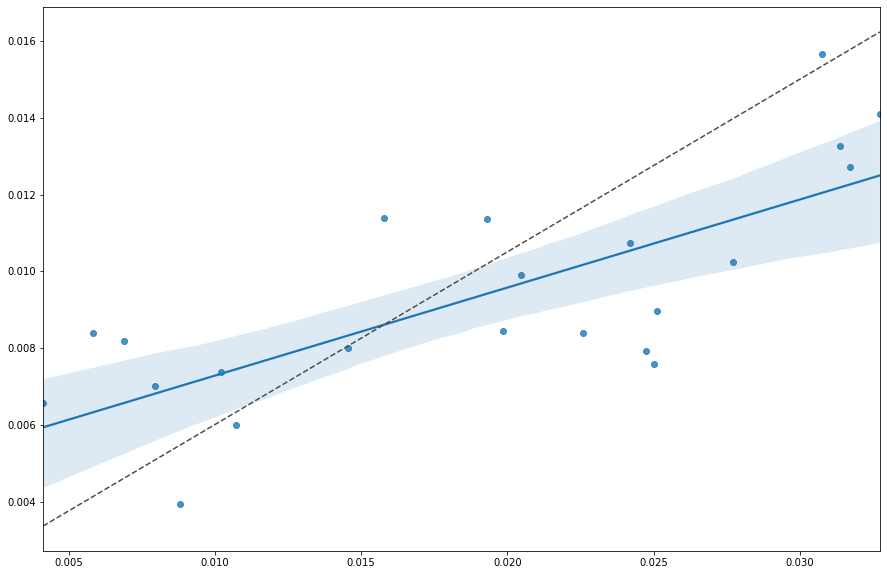

In [48]:
scores_val1_series = pd.Series(scores_val1)
scores_test_series = pd.Series(scores_test)

import seaborn as sns
%pylab inline

fig, ax = pylab.subplots(1,1, figsize=(15,10))

sns.regplot(x=scores_val1_series, y=scores_test_series, ax=ax)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

## Gerando Diversidade: Combinações de Features

In [50]:
feature_groups = ['feature_intelligence', 
                  'feature_charisma', 
                  'feature_strength', 
                  'feature_dexterity', 
                  'feature_constitution', 
                  'feature_wisdom']

In [51]:
from lightgbm import LGBMRegressor

### LGBM para 1 Feature

Treina um modelo em cada feature.

In [52]:
# loop
for group in feature_groups:
    
    # Pegamos os melhores parâmetros que encontramos naquele treinamento realizado anteriormente
    num_leaves, min_data_in_leaf, learning_rate = [130, 369, 0.009]
    
    
    mdl = LGBMRegressor(num_leaves=num_leaves,
                        min_data_in_leaf=min_data_in_leaf,
                        learning_rate=learning_rate, 
                        n_estimators=100, 
                        random_state=0)
    
    mdl.fit(X_train0.filter(regex=group, axis=1), y_train0)

    p = mdl.predict(X_train1.filter(regex=group,axis=1))
    
    model_name_train1 = "./preds_train1/lgbm_feature_groups_{}.pkl.z".format(group) 
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1.filter(regex=group,axis=1))
    
    model_name_val1 = "./preds_val1/lgbm_feature_groups_{}.pkl.z".format(group) 
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test.filter(regex=group,axis=1))
    
    model_name_test = "./preds_test/lgbm_feature_groups_{}.pkl.z".format(group) 
    jb.dump(p, model_name_test)

    print(group, metric)
    print()

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence 0.00374063608434927

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_charisma 0.01113070841236179

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_strength 0.006697064024431434

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_dexterity 0.009411367200089676

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_constitution 0.0060611470084215215

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_wisdom 0.004598225504345016



### LGBM para 2 Features

Agora treinamos um modelo para cada combinação de duas features.

In [54]:
from itertools import combinations

for group1, group2 in combinations(feature_groups, 2):
    
    num_leaves, min_data_in_leaf, learning_rate = [130, 369, 0.009]
    
    mdl = LGBMRegressor(num_leaves=num_leaves,
                        min_data_in_leaf=min_data_in_leaf,
                        learning_rate=learning_rate, 
                        n_estimators=100,
                        random_state=0)
    
    selected = []
    
    for f in X_train0.columns:
        if group1 in f or group2 in f:
            selected.append(f)

    mdl.fit(X_train0[selected], y_train0)

    p = mdl.predict(X_train1[selected])
    
    model_name_train1 = "./preds_train1/lgbm_feature_groups_{}_{}.pkl.z".format(group1, group2) 
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1[selected])
    
    model_name_val1 = "./preds_val1/lgbm_feature_groups_{}_{}.pkl.z".format(group1, group2) 
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test[selected])
    
    model_name_test = "./preds_test/lgbm_feature_groups_{}_{}.pkl.z".format(group1, group2) 
    jb.dump(p, model_name_test)

    print(group1, group2, metric)
    print()

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_charisma 0.018111292644637546

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_strength 0.006629157247998499

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_dexterity 0.0105771090584426

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_constitution 0.012879506778302852

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_wisdom 0.010342135317408909

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be 

### LGBM para 3 Features

Agora treinamos um modelo para cada combinação de três features.

In [55]:
from itertools import combinations

for group1, group2, group3 in combinations(feature_groups, 3):
    
    num_leaves, min_data_in_leaf, learning_rate = [130, 369, 0.009]
    
    
    mdl = LGBMRegressor(num_leaves=num_leaves,
                        min_data_in_leaf=min_data_in_leaf,
                        learning_rate=learning_rate, 
                        n_estimators=100,
                        random_state=0)
    
    selected = []
    
    for f in X_train0.columns:
        if group1 in f or group2 in f or group3 in f:
            selected.append(f)

    
    mdl.fit(X_train0[selected], y_train0)

    p = mdl.predict(X_train1[selected])
    
    model_name_train1 = "./preds_train1/lgbm_feature_groups_{}_{}_{}.pkl.z".format(group1, group2, group3) 
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1[selected])
    
    model_name_val1 = "./preds_val1/lgbm_feature_groups_{}_{}_{}.pkl.z".format(group1, group2, group3) 
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test[selected])
    
    model_name_test = "./preds_test/lgbm_feature_groups_{}_{}_{}.pkl.z".format(group1, group2, group3) 
    jb.dump(p, model_name_test)

    print(group1, group2, group3, metric)
    print()

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_charisma feature_strength 0.01341732390308576

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_charisma feature_dexterity 0.022151914400485296

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_charisma feature_constitution 0.018827256872208417

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_charisma feature_wisdom 0.017326460768674265

[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
feature_intelligence feature_strength feature_dexterity 0.019416040984

## Gerando Diversidade: Modelos Diferentes

### Rede Neural com Arquitetura Diferente

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [57]:
class MLPRegressorTorch(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3, drop1, drop2, drop3):
        super(MLPRegressorTorch,self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1)
        self.drop1 = nn.Dropout(drop1)
        self.hidden2 = nn.Linear(hidden1, hidden2)
        self.drop2 = nn.Dropout(drop2)
        self.hidden3 = nn.Linear(hidden2, hidden3)
        self.drop3 = nn.Dropout(drop3)
        self.out = nn.Linear(hidden3, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.drop1(x)
        x = F.relu(self.hidden2(x))
        x = self.drop2(x)
        x = F.relu(self.hidden3(x))
        x = self.drop3(x)
        return self.out(x)
    
    
#MLPRegressorTorch(X_train0.shape[1], 10, 10)(torch.from_numpy(X_train0.values).float())

In [58]:
from skopt import gp_minimize

X_train0_t = torch.from_numpy(X_train0.values).float().cuda()
y_train0_t = torch.from_numpy(y_train0.values).float().unsqueeze(dim=-1).cuda()

X_train1_t = torch.from_numpy(X_train1.values).float().cuda()
X_val1_t = torch.from_numpy(X_val1.values).float().cuda()
X_test_t = torch.from_numpy(X_test.values).float().cuda()


def tune_mlp(params):
    #scaling?
    torch.manual_seed(0)
    hidden1, hidden2, hidden3, drop1, drop2, drop3, learning_rate = params
    mdl = MLPRegressorTorch(X_train0.shape[1], hidden1, hidden2, hidden3, drop1, drop2, drop3).cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(mdl.parameters(), lr=learning_rate)
    
    for epoch in range(300): 
        optimizer.zero_grad()

        p = mdl(X_train0_t)
        loss = criterion(p, y_train0_t)
        loss.backward()
        optimizer.step()
    
    p = mdl(X_train1_t).detach().cpu().numpy()
    model_name_train1 = "./preds_train1/mlp_{}_{}_{}_{}_{}_{}_{}.pkl.z".format(hidden1, 
                                                                   hidden2, 
                                                                   hidden3,
                                                                   drop1,
                                                                   drop2,
                                                                   drop3,
                                                                   learning_rate) 
    jb.dump(p, model_name_train1)
    #print(p)
    
    metric = spearmanr(y_train1.values,p).correlation
    
    p = mdl(X_val1_t).detach().cpu().numpy()
    model_name_val1 = "./preds_val1/mlp_{}_{}_{}_{}_{}_{}_{}.pkl.z".format(hidden1, 
                                                                   hidden2, 
                                                                   hidden3,
                                                                   drop1,
                                                                   drop2,
                                                                   drop3,
                                                                   learning_rate)
    jb.dump(p, model_name_val1)
    
    p = mdl(X_test_t).detach().cpu().numpy()
    model_name_test = "./preds_test/mlp_{}_{}_{}_{}_{}_{}_{}.pkl.z".format(hidden1, 
                                                                   hidden2, 
                                                                   hidden3,
                                                                   drop1,
                                                                   drop2,
                                                                   drop3,
                                                                   learning_rate) 
    jb.dump(p, model_name_test)
    
    print(params, metric)
    print()
    
    return -metric

In [60]:
space = [(500, 2000),
         (500, 2000),
         (500, 2000),
         (0.0, 0.95),
         (0.0, 0.95),
         (0.0, 0.95),
         (1e-6, 1e-3, 'log-uniform')]

res = gp_minimize(tune_mlp, space, random_state=0, verbose=1, n_calls=11)

Iteration No: 1 started. Evaluating function at random point.


RuntimeError: CUDA out of memory. Tried to allocate 754.00 MiB (GPU 0; 4.00 GiB total capacity; 2.26 GiB already allocated; 739.39 MiB free; 2.26 GiB reserved in total by PyTorch)

### XGB

In [63]:
from xgboost import XGBRegressor

#### XGB com Todas as Features

Foi melhor que a nossa stacking inicial toda... mas note que usamos 2000 árvores, ao contrario das 100 que tinhamos utilizado antes.

In [65]:
mdl = XGBRegressor(max_depth=5, 
                   learning_rate=0.01, 
                   n_estimators=2000, 
                   colsample_bytree=0.1, 
                   #tree_method='gpu_hist', 
                   gpu_id=0)

mdl.fit(X_train0, y_train0)

p = mdl.predict(X_train1)

model_name_train1 = "./preds_train1/xgb_default.pkl.z"
jb.dump(p, model_name_train1)

metric = spearmanr(y_train1.values,p).correlation

p = mdl.predict(X_val1)

model_name_val1 = "./preds_val1/xgb_default.pkl.z" 
jb.dump(p, model_name_val1)

p = mdl.predict(X_test)

model_name_test = "./preds_test/xgb_default.pkl.z"
jb.dump(p, model_name_test)

print(metric)

0.03794601484541533


#### XGB para 1 Feature

In [66]:
feature_groups = ['feature_intelligence', 
                  'feature_charisma', 
                  'feature_strength', 
                  'feature_dexterity', 
                  'feature_constitution', 
                  'feature_wisdom']

for group in feature_groups:
    mdl = XGBRegressor(max_depth=5, 
                       learning_rate=0.01, 
                       n_estimators=2000, 
                       colsample_bytree=0.1, 
                       #tree_method='gpu_hist', 
                       gpu_id=0)
    
    mdl.fit(X_train0.filter(regex=group,axis=1), y_train0)

    p = mdl.predict(X_train1.filter(regex=group,axis=1))
    
    model_name_train1 = "./preds_train1/xgb_feature_groups_{}.pkl.z".format(group) 
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1.filter(regex=group,axis=1))
    
    model_name_val1 = "./preds_val1/xgb_feature_groups_{}.pkl.z".format(group) 
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test.filter(regex=group,axis=1))
    
    model_name_test = "./preds_test/xgb_feature_groups_{}.pkl.z".format(group) 
    jb.dump(p, model_name_test)

    print(group, metric)
    print()

feature_intelligence 0.004579789785842799

feature_charisma 0.011202050022626642

feature_strength 0.009468585723825215

feature_dexterity 0.010706552360754863

feature_constitution 0.00946472199603127

feature_wisdom 0.011403077777362953



#### XGB para 2 Features

In [67]:
from itertools import combinations

for group1, group2 in combinations(feature_groups, 2):
    
    mdl = XGBRegressor(max_depth=5, 
                       learning_rate=0.01, 
                       n_estimators=2000, 
                       colsample_bytree=0.1, 
                       #tree_method='gpu_hist', 
                       gpu_id=0)
  
    
    selected = []
    
    for f in X_train0.columns:
        if group1 in f or group2 in f:
            selected.append(f)

    
    mdl.fit(X_train0[selected], y_train0)

    p = mdl.predict(X_train1[selected])
    
    model_name_train1 = "./preds_train1/xgb_feature_groups_{}_{}.pkl.z".format(group1, group2) 
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1[selected])
    
    model_name_val1 = "./preds_val1/xgb_feature_groups_{}_{}.pkl.z".format(group1, group2) 
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test[selected])
    
    model_name_test = "./preds_test/xgb_feature_groups_{}_{}.pkl.z".format(group1, group2) 
    jb.dump(p, model_name_test)

    print(group1, group2, metric)
    print()

feature_intelligence feature_charisma 0.019793489077801728

feature_intelligence feature_strength 0.014698624866872938

feature_intelligence feature_dexterity 0.016303557454322527

feature_intelligence feature_constitution 0.01667758694274272

feature_intelligence feature_wisdom 0.01651476234315524

feature_charisma feature_strength 0.01609290721375223

feature_charisma feature_dexterity 0.022248943663177135

feature_charisma feature_constitution 0.017361863745583354

feature_charisma feature_wisdom 0.020585756102606535

feature_strength feature_dexterity 0.019246912724846122

feature_strength feature_constitution 0.011981485399881192

feature_strength feature_wisdom 0.013711108763284465

feature_dexterity feature_constitution 0.02259955221315074

feature_dexterity feature_wisdom 0.02299917641865188

feature_constitution feature_wisdom 0.015698667240184726



#### XGB para 3 Features

In [68]:
from itertools import combinations

for group1, group2, group3 in combinations(feature_groups, 3):
    
    mdl = XGBRegressor(max_depth=5, 
                       learning_rate=0.01, 
                       n_estimators=2000, 
                       colsample_bytree=0.1, 
                       tree_method='gpu_hist', 
                       gpu_id=0)
      
    selected = []
    
    for f in X_train0.columns:
        if group1 in f or group2 in f or group3 in f:
            selected.append(f)
    
    mdl.fit(X_train0[selected], y_train0)

    p = mdl.predict(X_train1[selected])
    
    model_name_train1 = "./preds_train1/xgb_feature_groups_{}_{}_{}.pkl.z".format(group1, group2, group3) 
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1[selected])
    
    model_name_val1 = "./preds_val1/xgb_feature_groups_{}_{}_{}.pkl.z".format(group1, group2, group3) 
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test[selected])
    
    model_name_test = "./preds_test/xgb_feature_groups_{}_{}_{}.pkl.z".format(group1, group2, group3) 
    jb.dump(p, model_name_test)

    print(group1, group2, group3, metric)
    print()

feature_intelligence feature_charisma feature_strength 0.021168226570951954

feature_intelligence feature_charisma feature_dexterity 0.026853476152643625

feature_intelligence feature_charisma feature_constitution 0.0238207944905206

feature_intelligence feature_charisma feature_wisdom 0.025974794745050538

feature_intelligence feature_strength feature_dexterity 0.023046342704775433

feature_intelligence feature_strength feature_constitution 0.01889545540184942

feature_intelligence feature_strength feature_wisdom 0.019436828251397375

feature_intelligence feature_dexterity feature_constitution 0.027136582162398084

feature_intelligence feature_dexterity feature_wisdom 0.025996225350558073



XGBoostError: [23:06:32] C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_gpu_hist.cu:786: Exception in gpu_hist: [23:06:32] c:\users\administrator\workspace\xgboost-win64_release_1.3.0\src\data\../common/device_helpers.cuh:400: Memory allocation error on worker 0: [23:06:32] c:\users\administrator\workspace\xgboost-win64_release_1.3.0\src\common\common.h:44: c:\users\administrator\workspace\xgboost-win64_release_1.3.0\src\common\device_helpers.cuh: 419: cudaErrorMemoryAllocation: out of memory
- Free memory: 193803060
- Requested memory: 195525472



## Gerando Diversidade: Combinações de Linhas

### Separação Por Soma Valores

Na separação de linhas, se houver uma variável categorica, tentamos separar as linhas por essa variável (exemplo: Todos os registros de um estado vão ser uma separação/bloco de linhas).

Em nosso caso não temos isso. Então fizemos uma separação por valor total da soma das linhas, separando-as pela soma total, dessa forma, linhas com valores semelhantes de soma ficam em um mesmo grupo.

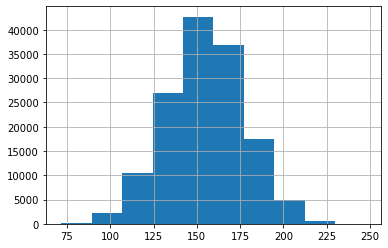

In [70]:
X_train0.sum(axis=1).hist()
plt.show()

In [71]:
# iterar por colunas de grupos se tivesse mais categoricas
buckets_Xtr0 = np.digitize(X_train0.sum(axis=1), bins=[125,150,175])
buckets_Xtr1 = np.digitize(X_train1.sum(axis=1), bins=[125,150,175])
buckets_Xvl1 = np.digitize(X_val1.sum(axis=1), bins=[125,150,175])
buckets_Xts = np.digitize(X_test.sum(axis=1), bins=[125,150,175])


p_tr1 = np.zeros(X_train1.shape[0])
p_vl1 = np.zeros(X_val1.shape[0])
p_ts = np.zeros(X_test.shape[0])

for bucket in np.unique(buckets_Xtr0):
    
    Xtr0 = X_train0[buckets_Xtr0 == bucket]
    ytr0 = y_train0[buckets_Xtr0 == bucket]
    
    mdl = XGBRegressor(max_depth=5, 
                       learning_rate=0.01, 
                       n_estimators=2000, 
                       colsample_bytree=0.1, 
                       #tree_method='gpu_hist', 
                       gpu_id=0)
    
    mdl.fit(Xtr0, ytr0)
    
    Xtr1 = X_train1[buckets_Xtr1 == bucket]
    p_tr1[buckets_Xtr1 == bucket] = mdl.predict(Xtr1)
    
    Xvl1 = X_val1[buckets_Xvl1 == bucket]
    p_vl1[buckets_Xvl1 == bucket] = mdl.predict(Xvl1)
    
    Xts = X_test[buckets_Xts == bucket]
    p_ts[buckets_Xts == bucket] = mdl.predict(Xts)

    
model_name_train1 = "./preds_train1/xgb_row_groups_buckets.pkl.z"
jb.dump(p_tr1, model_name_train1)

metric = spearmanr(y_train1.values,p_tr1).correlation

model_name_val1 = "./preds_val1/xgb_row_groups_buckets.pkl.z"
jb.dump(p_vl1, model_name_val1)

model_name_test = "./preds_test/xgb_row_groups_buckets.pkl.z"
jb.dump(p_ts, model_name_test)

print(metric)
print()

0.02759297403152932



### Separação Por Correlação

Semelhante ao anterior, mas agora buscamos as features com maior correlação (positiva ou negativa) com a target e pagamos as 10 mais correlacionadas.

In [72]:
c = X_train0.corrwith(y_train0, method='spearman')
most_corr = c.abs().sort_values().tail(10).index


#iterar por colunas de grupos se tivesse mais categoricas
for col in most_corr:

    p_tr1 = np.zeros(X_train1.shape[0])
    p_vl1 = np.zeros(X_val1.shape[0])
    p_ts = np.zeros(X_test.shape[0])

    for bucket in X_train0[col].unique():

        Xtr0 = X_train0[X_train0[col] == bucket]
        ytr0 = y_train0[X_train0[col] == bucket]

        mdl = XGBRegressor(max_depth=5, 
                           learning_rate=0.01, 
                           n_estimators=2000, 
                           colsample_bytree=0.1, 
                           #tree_method='gpu_hist', 
                           gpu_id=0)
        
        mdl.fit(Xtr0, ytr0)

        Xtr1 = X_train1[X_train1[col] == bucket]
        p_tr1[X_train1[col] == bucket] = mdl.predict(Xtr1)

        Xvl1 = X_val1[X_val1[col] == bucket]
        p_vl1[X_val1[col] == bucket] = mdl.predict(Xvl1)

        Xts = X_test[X_test[col] == bucket]
        p_ts[X_test[col] == bucket] = mdl.predict(Xts)


    model_name_train1 = "./preds_train1/xgb_row_groups_most_corr_{}.pkl.z".format(col)
    jb.dump(p_tr1, model_name_train1)

    metric = spearmanr(y_train1.values,p_tr1).correlation

    model_name_val1 = "./preds_val1/xgb_row_groups_most_corr_{}.pkl.z".format(col)
    jb.dump(p_vl1, model_name_val1)

    model_name_test = "./preds_test/xgb_row_groups_most_corr_{}.pkl.z".format(col)
    jb.dump(p_ts, model_name_test)

    print(col, metric)
    print()

feature_constitution30 0.025949039636915756

feature_charisma37 0.027526460821600384

feature_charisma69 0.023645841348983038

feature_charisma19 0.027577746902233618

feature_wisdom42 0.029037658521371867

feature_wisdom36 0.028352388252477906

feature_strength34 0.021693348223641606

feature_strength14 0.02040854674801827

feature_dexterity7 0.025865277697509688

feature_dexterity4 0.029745931426478488



### Separação Por Tempo

Separamos as linhas com base nas eras.

In [73]:
buckets_Xtr0 = np.digitize(train_train_level0['era'], bins=[10, 20, 30, 40])

for bucket in np.unique(buckets_Xtr0):

    Xtr0 = X_train0[buckets_Xtr0 == bucket]
    ytr0 = y_train0[buckets_Xtr0 == bucket]

    mdl = XGBRegressor(max_depth=5, 
                       learning_rate=0.01, 
                       n_estimators=2000, 
                       colsample_bytree=0.1, 
                       #tree_method='gpu_hist', 
                       gpu_id=0)
    
    mdl.fit(Xtr0, ytr0)

    p = mdl.predict(X_train1)
    model_name_train1 = "./preds_train1/xgb_row_groups_eras_{}.pkl.z".format(bucket)
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1)
    model_name_val1 = "./preds_val1/xgb_row_groups_eras_{}.pkl.z".format(bucket)
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test)
    model_name_test = "./preds_test/xgb_row_groups_eras_{}.pkl.z".format(bucket)
    jb.dump(p, model_name_test)


    print(bucket, metric)
    print()

0 0.02310342060393435

1 0.026401032453119033

2 0.026725069622356507

3 0.027500300539836955

4 0.010149563903710615



## Gerando Diversidade: Hiperparâmetros

### Manual

In [74]:
# Profundidade rasa, média e profunda (risco overfitting)
for depth in [1, 5, 10]:
    
    mdl = XGBRegressor(max_depth=depth,
                       learning_rate=0.01,
                       n_estimators=2000,
                       colsample_bytree=0.1,
                       #tree_method='gpu_hist',
                       gpu_id=0)
    
    mdl.fit(X_train0, y_train0)

    p = mdl.predict(X_train1)
    
    model_name_train1 = "./preds_train1/xgb_depth_{}.pkl.z".format(depth)
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1)
    
    model_name_val1 = "./preds_val1/xgb_depth_{}.pkl.z".format(depth)
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test)
    
    model_name_test = "./preds_test/xgb_depth_{}.pkl.z".format(depth)
    jb.dump(p, model_name_test)

    print(metric)

0.023484027981592888
0.03794601484541533
0.032266006786126976


### Random

In [75]:
def gen_xgb(seed):
    
    np.random.seed(seed)
    depth = np.random.randint(1,11)
    learning_rate = np.random.uniform(1e-3, 5e-2)
    n_estimators = np.random.randint(100, 5000)
    colsample_bytree = np.random.uniform(0.05, 0.95)
    subsample = np.random.uniform(0.05, 0.95)
    
    mdl = XGBRegressor(max_depth=depth,
                       learning_rate=learning_rate,
                       n_estimators=n_estimators,
                       colsample_bytree=colsample_bytree, 
                       subsample=subsample,
                       #tree_method='gpu_hist',
                       gpu_id=0,
                       seed=seed)
    
    mdl.fit(X_train0, y_train0)

    p = mdl.predict(X_train1)
    
    model_name_train1 = "./preds_train1/xgb_rhyper_{}.pkl.z".format(seed)
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1)
    
    model_name_val1 = "./preds_val1/xgb_rhyper_{}.pkl.z".format(seed)
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test)
    
    model_name_test = "./preds_test/xgb_rhyper_{}.pkl.z".format(seed)
    jb.dump(p, model_name_test)

    print(seed, depth, learning_rate, n_estimators, colsample_bytree, subsample, metric)
    
for seed in range(10):
    gen_xgb(seed)

0 6 0.042369021680469854 4959 0.5403948646972071 0.4312893194050142 0.02264096378677319
1 6 0.049862055736004565 1005 0.32209931536865577 0.18208030173540174 0.018417548697186894
2 9 0.010069021830487138 3706 0.9029575503750902 0.48627418710538006 0.028068046982699192
3 9 0.03569924330828714 1068 0.5097448446778967 0.8536522589128892 0.027298761308558107
4 8 0.009462071222525337 3771 0.5981320413049752 0.587800584692363 0.02873841936190224
5 4 0.0037038260747930584 1825 0.23604723980548376 0.8767498171441294 0.03373588521467743


XGBoostError: bad allocation

## Gerando Diversidade: Outras Maneiras

### Gerando Diversidade: Outras Maneiras - Classificação

Nesse exemplo nossa variável alvo pode ser entendida como uma classificação. Veja que ela é separada por 0.25, como se fosse classes. Então pode fazer sentido tratar como um problema de classificação.

In [76]:
y_train0.unique()

array([0.5 , 0.25, 0.75, 0.  , 1.  ])

In [77]:
labels = {0.: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1.:4}
y_train0 = y_train0.map(labels)
y_train0

0         2
1         1
2         1
3         1
4         3
         ..
142092    1
142093    2
142094    2
142095    2
142096    1
Name: target, Length: 142097, dtype: int64

In [78]:
label_values = np.array([0., 0.25, 0.5, 0.75, 1.0])

In [80]:
from xgboost import XGBClassifier

mdl = XGBClassifier(max_depth=5,
                    learning_rate=0.01,
                    n_estimators=2000,
                    colsample_bytree=0.1,
                    #tree_method='gpu_hist',
                    gpu_id=0)

mdl.fit(X_train0, y_train0)

p = mdl.predict_proba(X_train1)

p = p.dot(label_values)

model_name_train1 = "./preds_train1/xgb_classifier.pkl.z"
jb.dump(p, model_name_train1)

metric = spearmanr(y_train1.values,p).correlation

p = mdl.predict_proba(X_val1)
p = p.dot(label_values)

model_name_val1 = "./preds_val1/xgb_classifier.pkl.z"
jb.dump(p, model_name_val1)

p = mdl.predict_proba(X_test)
p = p.dot(label_values)

model_name_test = "./preds_test/xgb_classifier.pkl.z"
jb.dump(p, model_name_test)

print(metric)

R:\Install\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:18:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.03486939591299764


### Gerando Diversidade: Outras Maneiras - Ranker

In [81]:
groups = train_train_level0.groupby("era").size().values
X_train0, y_train0 = train_train_level0.filter(regex=r'feature', axis=1), train_train_level0['target']

In [83]:
from xgboost import XGBRanker

mdl = XGBRanker(max_depth=5,
                learning_rate=0.01,
                n_estimators=2000,
                colsample_bytree=0.1,
                #tree_method='gpu_hist',
                gpu_id=0)

mdl.fit(X_train0, y_train0, group=groups)

p_tr1 = np.zeros(X_train1.shape[0])

for era in train_train_level1['era'].unique():
    mask = train_train_level1['era'] == era
    X = X_train1[mask]
    p_tr1[mask] = mdl.predict(X)
    
model_name_train1 = "./preds_train1/xgb_ranker_era.pkl.z"
jb.dump(p_tr1, model_name_train1)

metric = spearmanr(y_train1.values,p_tr1).correlation
    
p_vl1 = np.zeros(X_val1.shape[0])

for era in train_train_level1['era'].unique():
    mask = train_valid_level1['era'] == era
    X = X_val1[mask]
    p_vl1[mask] = mdl.predict(X)
    
model_name_val1 = "./preds_val1/xgb_ranker_era.pkl.z"
jb.dump(p_vl1, model_name_val1)
    
p_ts = np.zeros(X_test.shape[0])

for era in test['era'].unique():
    mask = test['era'] == era
    X = X_test[mask]
    p_ts[mask] = mdl.predict(X)
    
model_name_test = "./preds_test/xgb_ranker_era.pkl.z"
jb.dump(p_ts, model_name_test)
    
print(metric)

[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1190: Empty dataset at worker: 0
[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1190: Empty dataset at worker: 0
[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1190: Empty dataset at worker: 0
[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1190: Empty dataset at worker: 0
[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1190: Empty dataset at worker: 0
[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1190: Empty dataset at worker: 0
[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1190: Empty dataset at worker: 0
[10:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1

TypeError: 'PytestTester' object is not subscriptable

### Gerando Diversidade: Outras Maneiras - Random Forest

In [84]:
from xgboost import XGBRegressor, XGBRFRegressor

#https://xgboost.readthedocs.io/en/latest/tutorials/rf.html#
#subsample = 0.5, paper ~= bagging
for depth in [5, 10, 20, 50, None]:
    
    mdl = XGBRegressor(max_depth=depth,
                       learning_rate=1.,
                       n_estimators=1,
                       num_parallel_tree=1000,
                       colsample_bytree=0.8,
                       colsample_bynode=0.8,
                       subsample=0.5,
                       #tree_method='gpu_hist',
                       gpu_id=0,
                       random_state=0)
    
    """
    mdl = XGBRFRegressor(max_depth=depth,
                         random_state=0,
                         #tree_method='gpu_hist',
                         gpu_id=0)
    """
    
    mdl.fit(X_train0, y_train0)

    p = mdl.predict(X_train1)
    
    model_name_train1 = "./preds_train1/xgb_rf_{}.pkl.z".format(depth)
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1)
    
    model_name_val1 = "./preds_val1/xgb_rf_{}.pkl.z".format(depth) 
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test)
    
    model_name_test = "./preds_test/xgb_rf_{}.pkl.z".format(depth)
    jb.dump(p, model_name_test)

    print(depth, metric)

5 0.026992768255832234
10 0.03165248747885688


XGBoostError: bad allocation

### Gerando Diversidade: Outras Maneiras - Boosted Random Forest

Aqui fazemos um boosting com Random Forest sendo usada em cada estimator.

In [ ]:
for trees in [2, 5, 10]:
    
    mdl = XGBRegressor(max_depth=None,
                       learning_rate=0.01,
                       n_estimators=2000,
                       colsample_bytree=0.1,
                       subsample=1.,
                       num_parallel_tree=trees,
                       #tree_method='gpu_hist',
                       gpu_id=0)
    
    mdl.fit(X_train0, y_train0)

    p = mdl.predict(X_train1)
    
    model_name_train1 = "./preds_train1/xgb_boosted_rf_{}.pkl.z".format(trees)
    jb.dump(p, model_name_train1)

    metric = spearmanr(y_train1.values,p).correlation

    p = mdl.predict(X_val1)
    
    model_name_val1 = "./preds_val1/xgb_boosted_rf_{}.pkl.z".format(trees)
    jb.dump(p, model_name_val1)

    p = mdl.predict(X_test)
    model_name_test = "./preds_test/xgb_boosted_rf_{}.pkl.z".format(trees)
    jb.dump(p, model_name_test)

    print(trees, metric)

## Seleção Stack Final

import glob
import re


preds_train1 = glob.glob("./preds_train1/*.pkl.z")
preds_val1 = glob.glob("./preds_val1/*.pkl.z")

df_train1 = []
for p_name in preds_train1:
    p = jb.load(p_name)
    p_name = re.search(r"train1/(.*)\.pkl.z", p_name).group(1)
    p_df = pd.DataFrame(p, columns=[p_name])
    df_train1.append(p_df)
    
    
df_val1 = [] 
scores_val1 = dict()
for p_name in preds_val1:
    p = jb.load(p_name)
    p_name = re.search(r"val1/(.*)\.pkl.z", p_name).group(1)
    p_df = pd.DataFrame(p, columns=[p_name])
    df_val1.append(p_df)
    scores_val1[p_name] = spearmanr(y_val1, p_df).correlation
    
    
df_train1 = pd.concat(df_train1, axis=1)
df_val1 = pd.concat(df_val1, axis=1)

df_test = [] 
scores_test = dict()
preds_test = glob.glob("./preds_test/*.pkl.z")
for p_name in preds_test:
    p = jb.load(p_name)
    p_name = re.search(r"test/(.*)\.pkl.z", p_name).group(1)
    p_df = pd.DataFrame(p, columns=[p_name])
    df_test.append(p_df)
    scores_test[p_name] = spearmanr(y_test, p_df).correlation
    
    
df_test = pd.concat(df_test, axis=1)

### Selection

In [ ]:
from sklearn.linear_model import Ridge

df_train1.columns[~df_train1.columns.isin(df_val1.columns)]

selected = ['xgb_classifier', 
            'xgb_feature_groups_feature_intelligence_feature_charisma_feature_dexterity',
            'xgb_depth_1', 'xgb_rhyper_5']

best_score = dist.max() + 1e-4 

for col in df_train1.columns:
    
    if col not in selected:
        
        Xtr = df_train1[selected+[col]].copy()
        Xval = df_val1[selected+[col]].copy()
    
        mdl = Ridge(alpha=1.)
        mdl.fit(Xtr, y_train1)

        p = mdl.predict(Xval)
        c = spearmanr(y_val1, p).correlation
        if c > best_score:
            print(col, c)
            best_score = c

### Permutation Test

In [ ]:
dist = []

for seed in range(100):
    
    Xtr = df_train1[selected].copy()
    Xval = df_val1[selected].copy()
    
    np.random.seed(seed)
    #print( Xtr.head())
    Xtr['random'] = np.random.permutation(Xtr.iloc[:, -1].values)
    Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)
    
    #print( Xtr.head())

    mdl = Ridge(alpha=1.)
    mdl.fit(Xtr, y_train1)

    p = mdl.predict(Xval)
    c = spearmanr(y_val1, p).correlation
    #print(c)
    dist.append(c)
    
dist = np.array(dist)
dist.max()

## Final

In [ ]:
Xtr = df_train1[selected].copy()
mdl = Ridge(alpha=1.)
mdl.fit(Xtr, y_train1)

p = mdl.predict(df_test[selected])

spearmanr(y_test, p).correlation

### Permutation Test com XGBRegressor

In [ ]:
selected = ['xgb_classifier', 'xgb_feature_groups_feature_charisma_feature_dexterity_feature_wisdom', 
            'xgb_feature_groups_feature_intelligence_feature_strength', 'lgbm_feature_groups_feature_constitution',
           'mlp_109_39_0.0009911332752617498', 'xgb_feature_groups_feature_intelligence_feature_charisma_feature_constitution',
           'lgbm_feature_groups_feature_strength_feature_dexterity', 'lgbm_feature_groups_feature_charisma_feature_dexterity_feature_constitution',
           'xgb_feature_groups_feature_intelligence_feature_wisdom']

In [ ]:
from xgboost import XGBRegressor
best_score = dist.max() + 1e-4
#best_score = 0

for col in df_train1.columns:
    if col not in selected:
        Xtr = df_train1[selected+[col]].copy()
        Xval = df_val1[selected+[col]].copy()
    
    
        mdl = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=0, colsample_bytree=0.1, subsample=0.25, 
                   tree_method='gpu_hist', gpu_id=0)
        mdl.fit(Xtr, y_train1)

        p = mdl.predict(Xval)
        c = spearmanr(y_val1, p).correlation
        if c > best_score:
            print(col, c)
            best_score = c
    

In [ ]:
dist = []
for seed in range(20):
    Xtr = df_train1[selected].copy()
    Xval = df_val1[selected].copy()
    
    np.random.seed(seed)
    #print( Xtr.head())
    Xtr['random'] = np.random.permutation(Xtr.iloc[:, -1].values)
    Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)
    
    #print( Xtr.head())

    mdl = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=0, colsample_bytree=0.1, subsample=0.25, 
                   tree_method='gpu_hist', gpu_id=0)
    mdl.fit(Xtr, y_train1)

    p = mdl.predict(Xval)
    c = spearmanr(y_val1, p).correlation
    #print(c)
    dist.append(c)
dist = np.array(dist)
dist.max()

## Stack Final com Média Ponderada de 2 Modelos

Vamos ver como combinar os dois modelos no segundo nível da Stack.

### Selected cols (xgb + ridge)

In [ ]:
from xgboost import XGBRegressor
selected_xgb = ['xgb_classifier', 'xgb_feature_groups_feature_charisma_feature_dexterity_feature_wisdom', 
            'xgb_feature_groups_feature_intelligence_feature_strength', 'lgbm_feature_groups_feature_constitution',
           'mlp_109_39_0.0009911332752617498', 'xgb_feature_groups_feature_intelligence_feature_charisma_feature_constitution',
           'lgbm_feature_groups_feature_strength_feature_dexterity', 'lgbm_feature_groups_feature_charisma_feature_dexterity_feature_constitution',
           'xgb_feature_groups_feature_intelligence_feature_wisdom']

Xtr = df_train1[selected_xgb].copy()
Xval = df_val1[selected_xgb].copy()
mdl = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=0, colsample_bytree=0.1, subsample=0.25, 
                   tree_method='gpu_hist', gpu_id=0)
mdl.fit(Xtr, y_train1)

p_xgb_s = mdl.predict(Xval)
c = spearmanr(y_val1, p_xgb_s).correlation
print(c)

In [ ]:
from sklearn.linear_model import Ridge
selected_ridge  = ['xgb_classifier', 'xgb_feature_groups_feature_intelligence_feature_charisma_feature_dexterity', 'xgb_depth_1', 'xgb_rhyper_5']

Xtr = df_train1[selected_ridge].copy()
Xval = df_val1[selected_ridge].copy()
mdl = Ridge(alpha=1.)
mdl.fit(Xtr, y_train1)

p_ridge_s = mdl.predict(Xval)
c = spearmanr(y_val1, p_ridge_s).correlation
print(c)

In [ ]:
# Testar diferentes combinações de peso para achar a melhor configuração
p = 0.3*p_ridge_s + 0.7*p_xgb_s
c = spearmanr(y_val1, p).correlation
print(c)

### Todas as cols (xgb + ridge)

In [ ]:
mdl = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=0, colsample_bytree=0.1, subsample=0.25, 
                   tree_method='gpu_hist', gpu_id=0)
mdl.fit(df_train1, y_train1)
p_xgb_t = mdl.predict(df_val1)
c = spearmanr(y_val1, p_xgb_t).correlation
print(c)

In [ ]:
mdl = Ridge(alpha=1.)
mdl.fit(df_train1, y_train1)
p_ridge_t = mdl.predict(df_val1)
c = spearmanr(y_val1, p_ridge_t).correlation
print(c)

In [ ]:
p = 0.2*p_ridge_t + 0.8*p_xgb_t
c = spearmanr(y_val1, p).correlation
print(c)

Com a selação de features o resultado foi levemente melhor.

## Teste Final

In [ ]:
Xtr = df_train1[selected_xgb].copy()
mdl = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=0, colsample_bytree=0.1, subsample=0.25, 
                   tree_method='gpu_hist', gpu_id=0)
mdl.fit(Xtr, y_train1)

p_xgb_test = mdl.predict(df_test[selected_xgb])

In [ ]:
from sklearn.linear_model import Ridge

Xtr = df_train1[selected_ridge].copy()
mdl = Ridge(alpha=1.)
mdl.fit(Xtr, y_train1)

p_ridge_test = mdl.predict(df_test[selected_ridge])

In [ ]:
p = 0.3*p_ridge_test + 0.7*p_xgb_test
c = spearmanr(y_test, p).correlation
print(c)

No teste perdemos um pouco a acertividade do modelo. Caiu para 0,20.

## E o feature set completo?

In [ ]:
Xtr = df_train1
mdl = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=0, colsample_bytree=0.1, subsample=0.25, 
                   tree_method='gpu_hist', gpu_id=0)
mdl.fit(Xtr, y_train1)

p_xgb_test = mdl.predict(df_test)

In [ ]:
Xtr = df_train1
mdl = Ridge(alpha=1.)
mdl.fit(Xtr, y_train1)

p_ridge_test = mdl.predict(df_test)

In [ ]:
p = 0.2*p_ridge_test + 0.8*p_xgb_test
c = spearmanr(y_test, p).correlation
print(c)

In [ ]:
print("Melhora val", 0.04476200295534109 / 0.04290319376803716 - 1 )
print("Melhor test", 0.024410911110673422 / 0.024535468740518818 - 1)

# Fim